This is a project for medical 3d voxel classification mission for machine learning course.

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as udata
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from GoogLeNet import GoogLeNet
from SimpleNet import SimpleNet
from SimpleNet import CropNet
from SimpleNet import DenseSharp
from tensorboardX import SummaryWriter
from DataProcessing import *
from DataAugment import train_data_process
from DataAugment import validate_data_process
from DataAugment import random_split
from DataAugment import test_data_process
from SimpleNet import SasakiNet, ResNet

hyper parameters definition

In [21]:
LR = 1e-3
batch_size = 20
batch_size_v = 1
EPOCH = 25

First read data from files

In [12]:
voxel_train, seg_train, total_batch_size = data_read('data_fake/train_val/candidate{}.npz', 584, notebook=True)
voxel_test, seg_test, test_batch_size = data_read('data_fake/test/candidate{}.npz', 584, notebook=True)
label = pd.read_csv('data_fake/train_val.csv').values[:, 1].astype(int)
print('Read Complete!')



Read Complete!


In [13]:
train_voxel, train_mask, train_label, validate_voxel, validate_mask, validate_label, train_size, validate_size = random_split(voxel_train, seg_train, label, train_set=4, ratio=0.05)
train_loader1, train_batch_size1 = train_data_process(train_voxel[0], train_mask[0], train_label[0], batch_size)
train_loader2, train_batch_size2 = train_data_process(train_voxel[1], train_mask[1], train_label[1], batch_size)
train_loader3, train_batch_size3 = train_data_process(train_voxel[2], train_mask[2], train_label[2], batch_size)
train_loader4, train_batch_size4 = train_data_process(train_voxel[3], train_mask[3], train_label[3], batch_size)
validate_loader, validate_batch_size = validate_data_process(validate_voxel, validate_mask, validate_label, batch_size_v)

In [14]:

test_loader, test_batch_size = test_data_process(voxel_test, seg_test, 1)

We can now build the model.

In [25]:
writer = SummaryWriter()
torch.cuda.empty_cache()
net1 = DenseSharp()
net2 = DenseSharp()
net3 = DenseSharp()
net4 = DenseSharp()

optimizer1 = torch.optim.SGD(net1.parameters(), momentum=0.9, lr=LR, weight_decay=0.02)
optimizer2 = torch.optim.SGD(net2.parameters(), momentum=0.9, lr=LR, weight_decay=0.02)
optimizer3 = torch.optim.SGD(net3.parameters(), momentum=0.9, lr=LR, weight_decay=0.02)
optimizer4 = torch.optim.SGD(net4.parameters(), momentum=0.9, lr=LR, weight_decay=0.02)
loss_func = nn.BCELoss()
max_accuracy = 0
min_loss = 1

In [26]:
net1.load_state_dict(torch.load('net1_best.pkl'))
net2.load_state_dict(torch.load('net2_best.pkl'))
net3.load_state_dict(torch.load('net3_best.pkl'))
net4.load_state_dict(torch.load('net4_best.pkl'))

<All keys matched successfully>

In [27]:
for epoch in range(EPOCH):    
    net1.train()
    net2.train()
    net3.train()
    net4.train()
    losses = []
    accuracys = []
    lossesv = []
    accuracysv = []
    net1.cuda()
    for j, (voxel, label) in enumerate(tqdm_notebook(train_loader1, desc='training epoch: {} set1'.format(epoch))):
        voxel = voxel.cuda()
        label = label.cuda()
        prediction = net1(voxel)
        loss = loss_func(prediction, label.to(dtype=torch.float32))
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        losses = np.append(losses, loss.item())
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0
        accuracy = (((prediction.round() == label.round()).sum()).to(dtype=torch.float32) / prediction.shape[0]).item()
        accuracys = np.append(accuracys, accuracy)
    net1.cpu()
    net2.cuda()
    for j, (voxel, label) in enumerate(tqdm_notebook(train_loader2, desc='training epoch: {} set2'.format(epoch))):
        voxel = voxel.cuda()
        label = label.cuda()
        prediction = net2(voxel)
        loss = loss_func(prediction, label.to(dtype=torch.float32))
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        losses = np.append(losses, loss.item())
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0
        accuracy = (((prediction.round() == label.round()).sum()).to(dtype=torch.float32) / prediction.shape[0]).item()
        accuracys = np.append(accuracys, accuracy)
    net2.cpu()
    net3.cuda()
    for j, (voxel, label) in enumerate(tqdm_notebook(train_loader3, desc='training epoch: {} set3'.format(epoch))):
        voxel = voxel.cuda()
        label = label.cuda()
        prediction = net3(voxel)
        loss = loss_func(prediction, label.to(dtype=torch.float32))
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        losses = np.append(losses, loss.item())
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0
        accuracy = (((prediction.round() == label.round()).sum()).to(dtype=torch.float32) / prediction.shape[0]).item()
        accuracys = np.append(accuracys, accuracy)
    net3.cpu()
    net4.cuda()
    for j, (voxel, label) in enumerate(tqdm_notebook(train_loader4, desc='training epoch: {} set4'.format(epoch))):
        voxel = voxel.cuda()
        label = label.cuda()
        prediction = net4(voxel)
        loss = loss_func(prediction, label.to(dtype=torch.float32))
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()
        losses = np.append(losses, loss.item())
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0
        accuracy = (((prediction.round() == label.round()).sum()).to(dtype=torch.float32) / prediction.shape[0]).item()
        accuracys = np.append(accuracys, accuracy)
    net4.cpu()
    del voxel
    del label
    del prediction
    del loss
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(accuracys)
    writer.add_scalar('scalar/avg_loss_train', avg_loss, epoch)
    writer.add_scalar('scalar/avg_accuracy_train', avg_accuracy, epoch)
    print('loss: ', avg_loss.item())
    print('accuracy: ', avg_accuracy.item())
    if avg_loss < min_loss:
        min_loss = avg_loss.item()
        torch.save(net1.state_dict(), 'net1_best.pkl')
        torch.save(net2.state_dict(), 'net2_best.pkl')
        torch.save(net3.state_dict(), 'net3_best.pkl')
        torch.save(net4.state_dict(), 'net4_best.pkl')
        print('net saved!')
    net1.eval()
    net2.eval()
    net3.eval()
    net4.eval()
    torch.cuda.empty_cache()
    net1.cuda()
    net2.cuda()
    net3.cuda()
    net4.cuda()
    for j, (voxel, label) in enumerate(tqdm_notebook(validate_loader, desc='validating epoch: {}'.format(epoch))):
        voxel = voxel.cuda()
        label = label.cuda()
        prediction1 = net1(voxel).detach()
        prediction2 = net2(voxel).detach()
        prediction3 = net3(voxel).detach()
        prediction4 = net4(voxel).detach()
        prediction = torch.stack((prediction1, prediction2, prediction3, prediction4), dim=0).mean(dim=0)
        loss = loss_func(prediction, label.to(dtype=torch.float32).squeeze())
        lossesv = np.append(lossesv, loss.item())
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0
        accuracy = (((prediction.round() == label.round()).sum()).to(dtype=torch.float32)).item()
        accuracysv = np.append(accuracysv, accuracy)
        del voxel
        del loss
    net1.cpu()
    net2.cpu()
    net3.cpu()
    net4.cpu()
    avg_loss = np.mean(lossesv)
    avg_accuracy = np.mean(accuracysv)
    writer.add_scalar('scalar/avg_loss_validate', avg_loss, epoch)
    writer.add_scalar('scalar/avg_accuracy_validate', avg_accuracy, epoch)
    print('loss: ', avg_loss.item())
    print('accuracy: ', avg_accuracy.item())
    
    


loss:  0.2823225162657244
accuracy:  0.9109375083020755
net saved!



loss:  0.8604943418254455
accuracy:  0.5333333333333333



loss:  0.31240605882235933
accuracy:  0.8792410833495004



loss:  0.7452193662524224
accuracy:  0.5



loss:  0.3119369045432125
accuracy:  0.8843750123466764



loss:  0.7494535585244496
accuracy:  0.43333333333333335



loss:  0.29806316564125673
accuracy:  0.8792410833495004



loss:  0.7995775230228901
accuracy:  0.5



loss:  0.27455872749643667
accuracy:  0.9084821524364608
net saved!



loss:  0.7481763417522113
accuracy:  0.5333333333333333



loss:  0.3057046527309077
accuracy:  0.8921875123466764



loss:  0.8183968012531598
accuracy:  0.5666666666666667



loss:  0.2588309704193047
accuracy:  0.9102678660835538
net saved!



loss:  0.8410367041826248
accuracy:  0.5333333333333333



loss:  0.2777895061299205
accuracy:  0.883705369063786



loss:  0.7659644107023875
accuracy:  0.43333333333333335



loss:  0.2499464862048626
accuracy:  0.9274553624647004
net saved!



loss:  0.8225103820363681
accuracy:  0.5333333333333333



loss:  0.24623105462108338
accuracy:  0.9216517955064774
net saved!



loss:  0.8147702395915986
accuracy:  0.43333333333333335



loss:  0.23974773593779122
accuracy:  0.9191964343190193
net saved!



loss:  0.8922545148059726
accuracy:  0.4



loss:  0.2124976482508438
accuracy:  0.9345982213105474
net saved!



loss:  0.8253172238667806
accuracy:  0.5333333333333333



loss:  0.24493125493505172
accuracy:  0.9223214355962617



loss:  0.7601936637113492
accuracy:  0.5333333333333333



loss:  0.2584215884229967
accuracy:  0.9037946515849659



loss:  0.7830391108989716
accuracy:  0.43333333333333335



loss:  0.22671039109783514
accuracy:  0.9281250089406967



loss:  0.9357160157213609
accuracy:  0.43333333333333335



loss:  0.2142157657071948
accuracy:  0.9352678614003318



loss:  0.7515210022528966
accuracy:  0.5333333333333333



loss:  0.24986598999904736
accuracy:  0.9100446520107133



loss:  0.7555488067368666
accuracy:  0.5



loss:  0.2133311661226409
accuracy:  0.929017862038953



loss:  0.9167735600844026
accuracy:  0.5333333333333333



loss:  0.1986860640213958
accuracy:  0.9357142895460129
net saved!



loss:  0.780102351307869
accuracy:  0.6



loss:  0.1924703847616911
accuracy:  0.9424107202461788
net saved!



loss:  0.8611619912087918
accuracy:  0.43333333333333335


KeyboardInterrupt: 

In [ ]:
###### ((prediction.round() == label.round()).sum()).to(dtype=torch.float32)

visualization

In [28]:
writer.close()
print(min_loss)

0.1924703847616911


In [23]:
net1.cpu()
net2.cpu()
net3.cpu()
net4.cpu()

DenseSharp(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (denseblock1): ModuleList(
    (0): DenseBlockLayer(
      (net): Sequential(
        (0): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv3d(64, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
    )
    (1): DenseBlockLayer(
      (net): Sequential(
        (0): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv3d(48, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
       

In [29]:
net1 = DenseSharp().cuda()
net2 = DenseSharp().cuda()
net3 = DenseSharp().cuda()
net4 = DenseSharp().cuda()
net1.eval()
net2.eval()
net3.eval()
net4.eval()
torch.cuda.empty_cache()
net1.load_state_dict(torch.load('net1_best.pkl'))
net2.load_state_dict(torch.load('net2_best.pkl'))
net3.load_state_dict(torch.load('net3_best.pkl'))
net4.load_state_dict(torch.load('net4_best.pkl'))
prediction = torch.zeros(test_batch_size)
for j, voxel in enumerate(tqdm_notebook(test_loader)):
    voxel = voxel.cuda()
    prediction1 = net1(voxel).detach()
    prediction2 = net2(voxel).detach()
    prediction3 = net3(voxel).detach()
    prediction4 = net4(voxel).detach()
    prediction[j] = torch.stack((prediction1, prediction2, prediction3, prediction4), dim=0).mean(dim=0)

In [30]:
submit = pd.read_csv('data/sampleSubmission.csv')
submit['Predicted'] = prediction.numpy()
submit.to_csv('submit122504.csv', index=False)


In [11]:
prediction_abs = prediction.clone()
prediction_abs[prediction_abs >= 0.5] = 1
prediction_abs[prediction_abs < 0.5] = 0
submit = pd.read_csv('data/sampleSubmission.csv')
submit['Predicted'] = prediction_abs.numpy()
submit.to_csv('submit121202_zc.csv', index=False)

In [9]:
print(prediction.cpu().numpy())


[0.13758601 0.39853567 0.5729278  0.506489   0.5833465  0.53347945
 0.67877686 0.71960217 0.32417572 0.54219353 0.5916967  0.43167403
 0.46626705 0.3595695  0.3484107  0.38188028 0.21037334 0.40309608
 0.50425607 0.25287503 0.28050932 0.11201568 0.64346504 0.50934905
 0.35416612 0.56873125 0.272726   0.5301209  0.58833766 0.54696596
 0.579993   0.19679317 0.51945317 0.2806113  0.71588206 0.6368913
 0.7520733  0.5550293  0.40929288 0.5259504  0.36259168 0.5277406
 0.6504245  0.30874258 0.19252434 0.43913198 0.34806448 0.6889239
 0.28263274 0.41209915 0.46972    0.45028785 0.44706985 0.44854596
 0.62522405 0.5876359  0.26585522 0.45028302 0.72669196 0.51345557
 0.6083715  0.39344472 0.627162   0.5479963  0.65569806 0.556294
 0.35628957 0.43741703 0.31874847 0.42738342 0.531029   0.42288446
 0.2568556  0.58820266 0.68625975 0.19939192 0.57271814 0.405576
 0.37345314 0.4239701  0.58196676 0.5399169  0.30828273 0.65128815
 0.5631617  0.40213495 0.6645725  0.4608126  0.5780384  0.48924953
 0

In [12]:
print(train_label)

[1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1
 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0
 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1
 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1
 1 1]


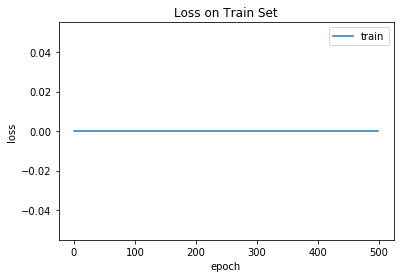

In [14]:
l1, = plt.plot(list(range(500)), accuracysv[2500:3000])
plt.legend(handles=[l1], labels=['train'], loc='best')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss on Train Set')
plt.show()


In [15]:
print()